### **Effect of Context Length on Claim Verification (If use Full Context)**

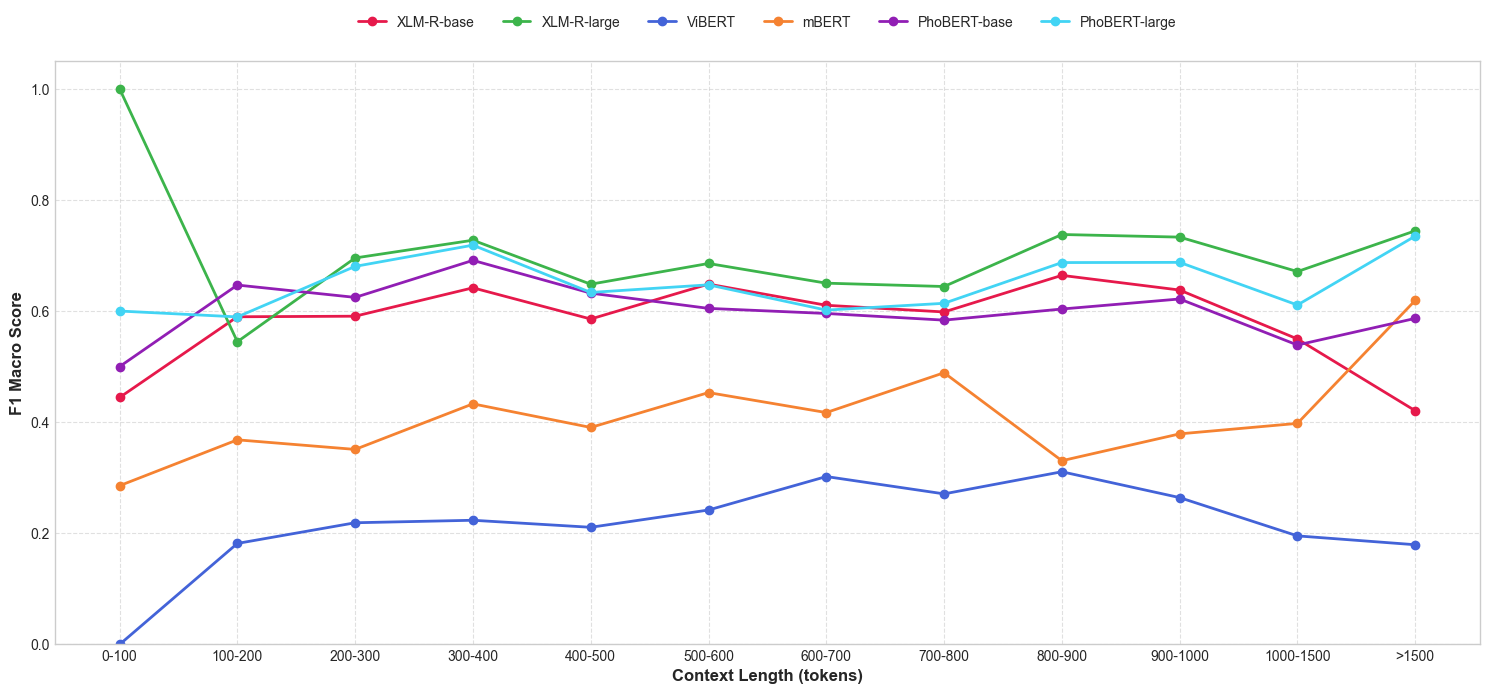

In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from underthesea import word_tokenize
from sklearn.metrics import f1_score

# --- 1. Cấu hình thông số và Mapping tên model ---
base_path = "claim_verification/test/results"
# Mapping để chuẩn hóa tên hiển thị và gán màu sắc riêng biệt
model_config = {
    "Namronaldo2004/Vifactcheck-xlm-roberta-base": {"label": "XLM-R-base", "color": "#E6194B"},      # Đỏ
    "Namronaldo2004/Vifactcheck-xlm-roberta-large": {"label": "XLM-R-large", "color": "#3CB44B"},    # Xanh lá
    "Namronaldo2004/Vifactcheck-ViBERT": {"label": "ViBERT", "color": "#4363D8"},                   # Xanh dương
    "Namronaldo2004/Vifactcheck-mBERT": {"label": "mBERT", "color": "#F58231"},                    # Cam
    "Namronaldo2004/Vifactcheck-phoBERT-base": {"label": "PhoBERT-base", "color": "#911EB4"},       # Tím
    "Namronaldo2004/Vifactcheck-phoBERT-large": {"label": "PhoBERT-large", "color": "#42D4F4"}      # Xanh lơ
}

bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 10000]
bin_labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600', 
              '600-700', '700-800', '800-900', '900-1000', '1000-1500', '>1500']

# --- 2. Xử lý dữ liệu ---
all_results = {}
cached_lengths = None

for raw_name, config in model_config.items():
    normalized_name = raw_name.replace("/", "_")
    file_path = os.path.join(base_path, f"results_full_context_{normalized_name}.json")
    
    if not os.path.exists(file_path):
        continue
        
    with open(file_path, 'r', encoding='utf-8') as f:
        details = json.load(f)['details']
    
    df = pd.DataFrame(details)
    
    if cached_lengths is None:
        df['length'] = df['evidence'].apply(lambda x: len(word_tokenize(x)))
        cached_lengths = df['length'].copy()
    else:
        df['length'] = cached_lengths

    df['bin'] = pd.cut(df['length'], bins=bins, labels=bin_labels, include_lowest=True)
    
    f1_list = []
    for label in bin_labels:
        subset = df[df['bin'] == label]
        if not subset.empty:
            f1_list.append(f1_score(subset['true_label'], subset['pred_label'], average='macro'))
        else:
            f1_list.append(None)
    
    all_results[config['label']] = {"scores": f1_list, "color": config['color']}

# --- 3. Visualization ---
plt.figure(figsize=(15, 7))
plt.grid(True, linestyle='--', alpha=0.6)

for model_name, data in all_results.items():
    plt.plot(bin_labels, data['scores'], marker='o', linewidth=2, 
             label=model_name, color=data['color'])

# Chỉnh trục Y bắt đầu từ 0
plt.ylim(0, 1.05)
plt.ylabel('F1 Macro Score', fontsize=12, fontweight='bold')
plt.xlabel('Context Length (tokens)', fontsize=12, fontweight='bold')

# Legend trên cùng 1 hàng, bỏ title
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), 
           ncol=6, frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

### **Effect of Num Evidences on Claim Verification (If use Gold Evidence)**

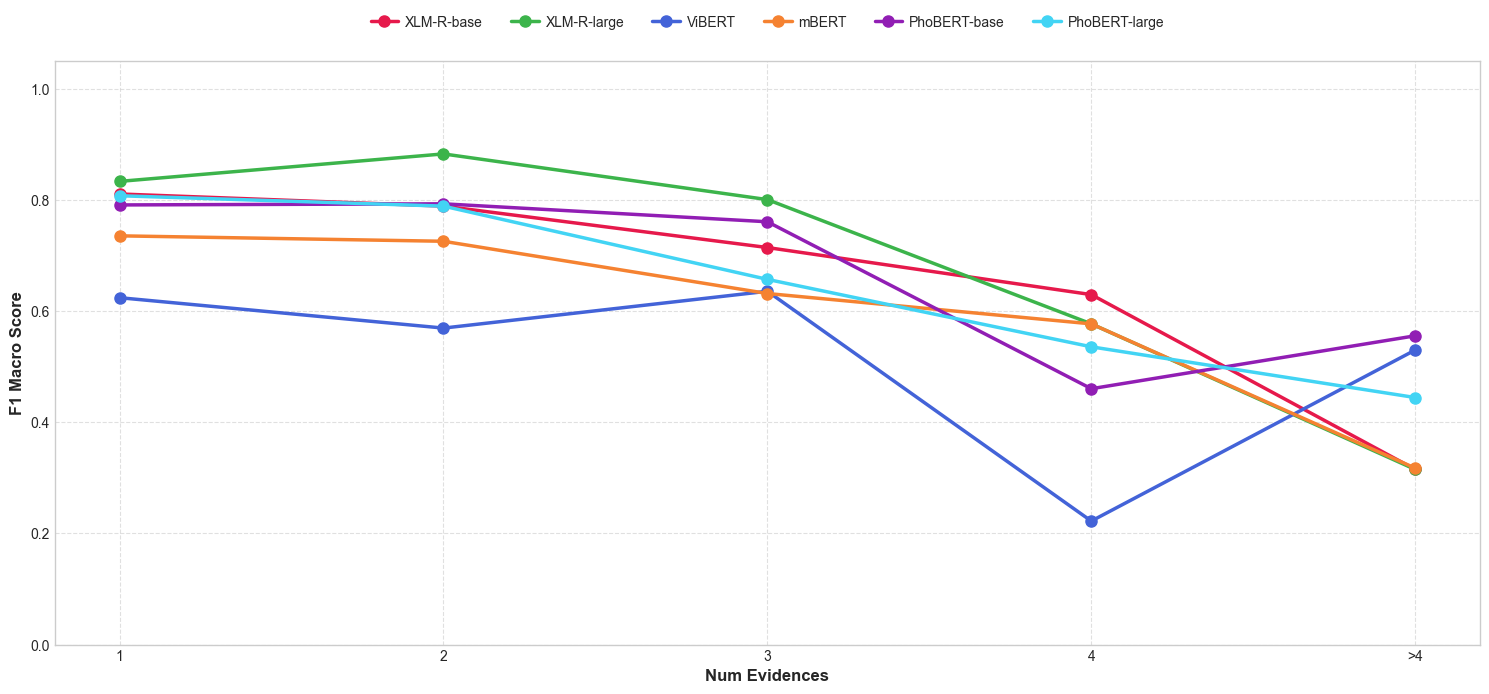

In [3]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# --- 1. Cấu hình thông số và Mapping ---
test_data_path = "../data/retrieval/test_data.json"
results_dir = "claim_verification/test/results"

model_config = {
    "Namronaldo2004/Vifactcheck-xlm-roberta-base-gold-evidence": {"label": "XLM-R-base", "color": "#E6194B"},
    "Namronaldo2004/Vifactcheck-xlm-roberta-large-gold-evidence": {"label": "XLM-R-large", "color": "#3CB44B"},
    "Namronaldo2004/Vifactcheck-ViBERT-gold-evidence": {"label": "ViBERT", "color": "#4363D8"},
    "Namronaldo2004/Vifactcheck-mBERT-gold-evidence": {"label": "mBERT", "color": "#F58231"},
    "Namronaldo2004/Vifactcheck-phoBERT-base-gold-evidence": {"label": "PhoBERT-base", "color": "#911EB4"},
    "Namronaldo2004/Vifactcheck-phoBERT-large-gold-evidence": {"label": "PhoBERT-large", "color": "#42D4F4"}
}

bin_labels = ["1", "2", "3", "4", ">4"]

# --- 2. Lấy số lượng bằng chứng (Num Evidences) từ test_data.json ---
with open(test_data_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

def get_evidence_bin(count):
    if count >= 5: return ">4"
    return str(count)

# Danh sách số lượng bằng chứng tương ứng với từng record (theo thứ tự)
evidence_bins = [get_evidence_bin(len(record.get('Evidence_List', []))) for record in test_data]

# --- 3. Xử lý dữ liệu từng model ---
all_results = {}

for raw_name, config in model_config.items():
    normalized_name = raw_name.replace("/", "_")
    file_path = os.path.join(results_dir, f"results_gold_evidence_{normalized_name}.json")
    
    if not os.path.exists(file_path):
        print(f"Warning: Missing {file_path}")
        continue
        
    with open(file_path, 'r', encoding='utf-8') as f:
        details = json.load(f)['details']
    
    df = pd.DataFrame(details)
    df['evidence_bin'] = evidence_bins[:len(df)] # Đảm bảo khớp số lượng record
    
    f1_list = []
    for label in bin_labels:
        subset = df[df['evidence_bin'] == label]
        if not subset.empty:
            score = f1_score(subset['true_label'], subset['pred_label'], average='macro')
            f1_list.append(score)
        else:
            f1_list.append(None)
    
    all_results[config['label']] = {"scores": f1_list, "color": config['color']}

# --- 4. Visualization ---
plt.figure(figsize=(15, 7))
plt.grid(True, linestyle='--', alpha=0.6)

for model_name, data in all_results.items():
    plt.plot(bin_labels, data['scores'], marker='o', markersize=8, linewidth=2.5, 
             label=model_name, color=data['color'])

# Định dạng trục
plt.ylim(0, 1.05)
plt.ylabel('F1 Macro Score', fontsize=12, fontweight='bold')
plt.xlabel('Num Evidences', fontsize=12, fontweight='bold')

# Legend trên 1 hàng, không khung
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), 
           ncol=6, frameon=False, fontsize=10, handletextpad=0.5)

plt.tight_layout()
plt.show()

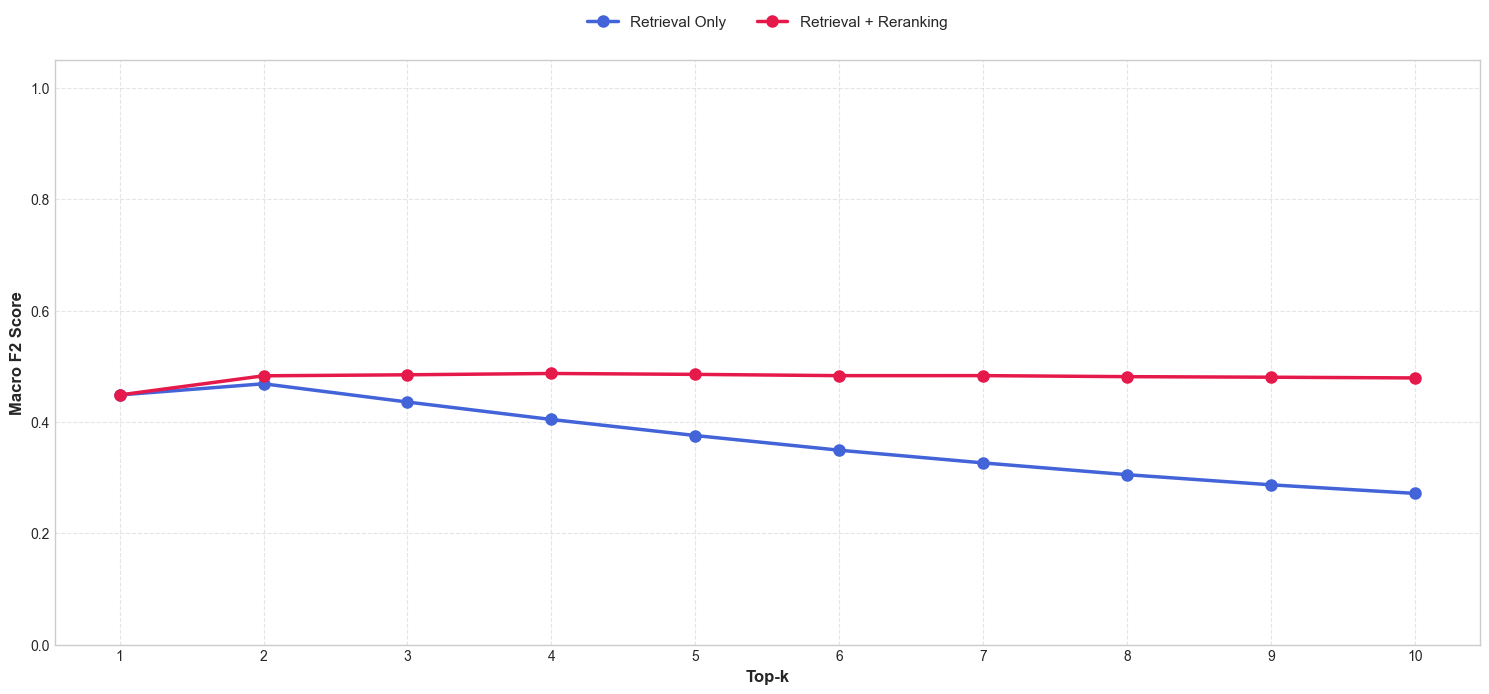

In [9]:
import json
import os
import matplotlib.pyplot as plt

# --- 1. Cấu hình đường dẫn (Nhớ kiểm tra ../ nếu chạy từ experiments/) ---
base_results_path = "evidence_selection/test/results"
k_range = list(range(1, 11))

methods_config = {
    "Retrieval Only": {
        "dir": "top_k",
        "file_pattern": "evidence_f2_results_top_{k}.json",
        "color": "#4363D8"  # Xanh dương
    },
    "Retrieval + Reranking": {
        "dir": "cer_top_k",
        "file_pattern": "evidence_cer_results_top_{k}.json",
        "color": "#E6194B"  # Đỏ
    }
}

# --- 2. Đọc dữ liệu ---
plot_data = {}
for method_name, config in methods_config.items():
    scores = []
    for k in k_range:
        file_path = os.path.join(base_results_path, config['dir'], config['file_pattern'].format(k=k))
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                scores.append(data.get('macro_avg_f2', 0))
        else:
            scores.append(0)
    plot_data[method_name] = scores

# --- 3. Visualization ---
plt.figure(figsize=(15, 7))
plt.grid(True, linestyle='--', alpha=0.5)

for method_name, scores in plot_data.items():
    # THAY ĐỔI TẠI ĐÂY: Chia cho 100 để chuẩn hóa về khoảng [0, 1]
    normalized_scores = [s / 100 for s in scores]
    
    plt.plot(k_range, normalized_scores, marker='o', markersize=8, linewidth=2.5,
             label=method_name, color=methods_config[method_name]['color'])

# Định dạng các trục
plt.xticks(k_range)
plt.ylim(0, 1.05) # Giờ đây dữ liệu đã khớp với giới hạn này
plt.xlabel('Top-k', fontsize=12, fontweight='bold')
plt.ylabel('Macro F2 Score', fontsize=12, fontweight='bold')

# Legend đặt trên cùng 1 hàng
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
           ncol=2, frameon=False, fontsize=11)

plt.tight_layout()
plt.show()